## A basic example of a Generative Adversarial Network.  Based in part on lecture from pydata 2018 in NYC.

In [ ]:
# !brew install graphviz
# !pip install -q pydot

In [1]:
# Import modules
from __future__ import division

import keras
import keras.backend as K
import numpy as np
import functools
from tqdm import tqdm, tqdm_notebook
from IPython.display import SVG
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras_sequential_ascii import sequential_model_to_ascii_printout
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
# set pandas options
pd.options.display.max_columns=500
pd.options.display.max_colwidth=1000

In [3]:
# Set plot style
plt.style.use('dark_background')

In [4]:
def plot_model(model):
    return SVG(keras.utils.vis_utils.model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Load data
* First, we'll use the cifar 10 data set.  
* It has 60,000 32x32 colour images representing 10 classes: 
    * airplanes, cars, birds, cats, deer, dogs, frogs, horses, shops, and trucks
* Each class has 6,000 images

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [6]:
# What is the distribution in pixel values?
x_train.max()

255

In [7]:
x_train.min()

0

In [8]:
x_test.max()

255

In [9]:
x_test.min()

0

In [10]:
# What are the unique classes? Are they the same in the training and testing set?
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [11]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Text(0.5,1,'Count of target classes in training set')

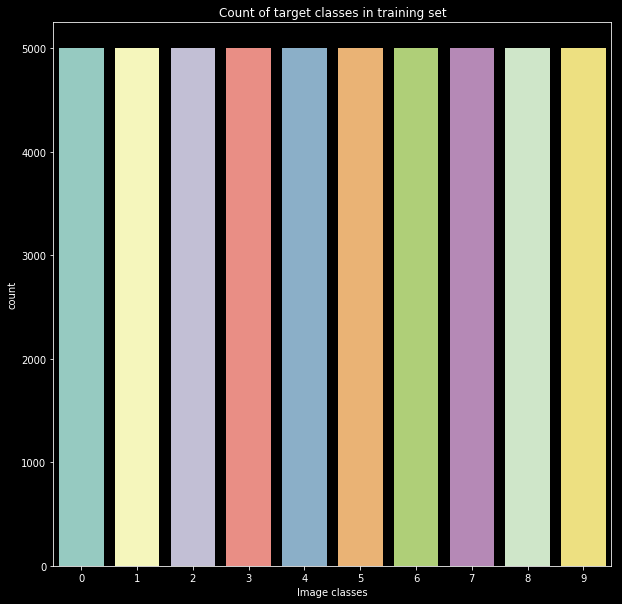

In [12]:
# So they are the same (all classes are reprented in the testing and training sets.)  Are the distributions the same-ish?
plt.figure(figsize=(10,10))
sns.countplot(x=0, data=pd.DataFrame(y_train))
plt.xlabel('Image classes')
plt.title('Count of target classes in training set')

Text(0.5,1,'Count of target classes in testing set')

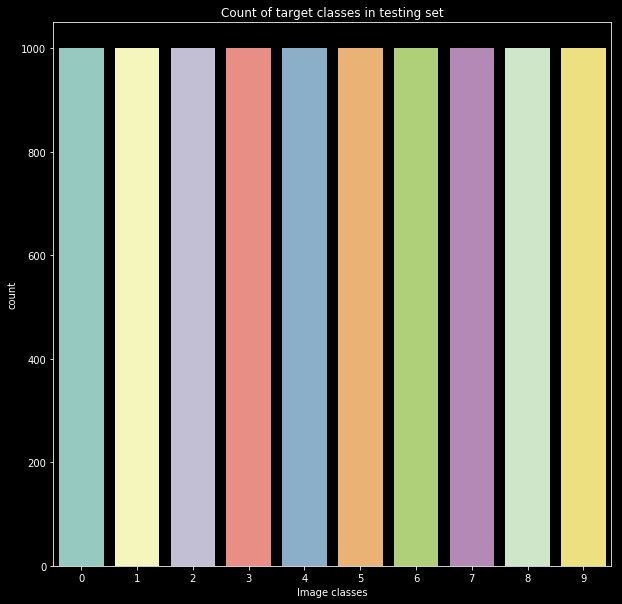

In [13]:
plt.figure(figsize=(10,10))
sns.countplot(x=0, data=pd.DataFrame(y_test))
plt.xlabel('Image classes')
plt.title('Count of target classes in testing set')

In [14]:
# So the distributions of the target classes looks the same in both the training and testing sets.  

In [15]:
# Now, we'll scale the pixel values to be between -1 and 1.  
x_train = (2/(x_train.max()))*x_train - 1
x_test = (2/(x_test.max()))*x_test - 1

In [16]:
print('training set pixel values scaled to {0} and {1}').format(np.min(x_train), np.max(x_train))
print('\n')
print('testing set pixel values scaled to {0} and {1}').format(np.min(x_test), np.max(x_test))

training set pixel values scaled to -1.0 and 1.0


testing set pixel values scaled to -1.0 and 1.0


# Convolutional neural network
* To start, let's try building a CNN classifier on this data.

In [17]:
# For convenience, use functools partial to define a basic convolutional layer which we'll be using several times. We'll use a 2D layer, as the inputs are 2D.
# filters: the dimensionality of the output subspace. We should try changing this.  
# kernel_size: setting this to 3 is equivalent to setting the height and width of the convolutional window to be 3x3
# strides: setting this to2 is equivalent to setting the strides of the convolution along the height and width to be 2x2
# padding: same means padding the input such that the output has the same length as the original input
conv = functools.partial(keras.layers.Conv2D, filters=50, kernel_size=3, strides=2, activation="relu", padding="same")

In [18]:
num_classes = len(np.unique(y_train))

In [27]:
# Initialize the model
classifier_cnn = keras.Sequential()

In [20]:
# The images in the training (and testing set) have dimensions:
x_train.shape[1:]

(32, 32, 3)

In [21]:
# The images are 32x32 pixels, with 3 colour channels in red, green, and blue.  The input layer needs to reflect this.  

In [28]:
# Add the input layer.
classifier_cnn.add(keras.layers.InputLayer(input_shape=x_train.shape[1:]))

In [29]:
# Add convolutional layers.  We'll try 3 convolutional layers.  What happens if we change this?
classifier_cnn.add(conv())
classifier_cnn.add(conv())
classifier_cnn.add(conv())

In [23]:
# After the first convolutional layer, the expected output shape should be (16, 16, 50), since we're using a stride of 2 in width and height, and the number of output filters
# is set to 50.  After the second conv layer, the output shape should be (8, 8, 50).  Finally, the third conv layer should result in an output of (4, 4, 50).

In [30]:
# Add a layer to flatten the vectors going through here
classifier_cnn.add(keras.layers.Flatten())

In [31]:
# To get the output classes, we'll want to get down to a 10 dimensional output vector.  We'll get the output out of a dense layer by first flattening the output of the last
# conv layer.  The results should be a vector of length 4x4x50 = 800.  This goes into a densely connected layer with a softmax activation function to get predicted classes.

In [32]:
# Add a dense layer for the output with softmax activation
classifier_cnn.add(keras.layers.Dense(num_classes, activation="softmax"))

In [34]:
classifier_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 50)        1400      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 50)          22550     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 50)          22550     
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                8010      
Total params: 54,510
Trainable params: 54,510
Non-trainable params: 0
_________________________________________________________________


In [35]:
# The summary above gives the expected dimensional outputs at each layer.

In [37]:
# We can visualize the network architecture
sequential_model_to_ascii_printout(classifier_cnn)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     32   32    3
          InputLayer     |   -------------------         0     0.0%
                       #####     32   32    3
              Conv2D    \|/  -------------------      1400     2.0%
                relu   #####     16   16   50
              Conv2D    \|/  -------------------     22550    41.0%
                relu   #####      8    8   50
              Conv2D    \|/  -------------------     22550    41.0%
                relu   #####      4    4   50
             Flatten   ||||| -------------------         0     0.0%
                       #####         800
               Dense   XXXXX -------------------      8010    14.0%
             softmax   #####          10


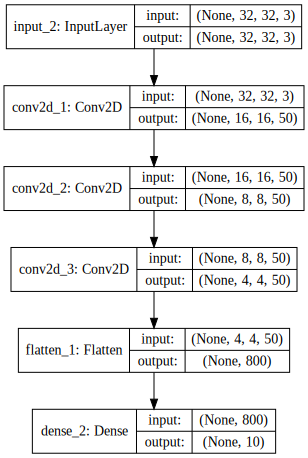

In [38]:
# Here's a nicer plot
plot_model(classifier_cnn)

In [39]:
# Compile the model. We use sparse_categorical_crossentropy as our targets are integers (if the target was hot encoded, we could use categorical_crossentropy, but we would
# absolutely have to hot-encode the target variable first).  The metric will be categorical accuracy.
classifier_cnn.compile(optimizer=keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics=['acc'])

In [40]:
# Fit the model.
classifier_cnn.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=10)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 21s 417us/step - loss: 1.4729 - acc: 0.4711 - val_loss: 1.2650 - val_acc: 0.5457
Epoch 2/10
50000/50000 [==============================] - 21s 420us/step - loss: 1.1541 - acc: 0.5894 - val_loss: 1.1151 - val_acc: 0.6030
Epoch 3/10
50000/50000 [==============================] - 21s 427us/step - loss: 1.0174 - acc: 0.6422 - val_loss: 1.0350 - val_acc: 0.6348
Epoch 4/10
50000/50000 [==============================] - 22s 432us/step - loss: 0.9201 - acc: 0.6761 - val_loss: 0.9792 - val_acc: 0.6585
Epoch 5/10
50000/50000 [==============================] - 21s 416us/step - loss: 0.8473 - acc: 0.7044 - val_loss: 0.9652 - val_acc: 0.6601
Epoch 6/10
50000/50000 [==============================] - 22s 431us/step - loss: 0.7864 - acc: 0.7261 - val_loss: 0.9551 - val_acc: 0.6720
Epoch 7/10
50000/50000 [==============================] - 21s 430us/step - loss: 0.7335 - acc: 0.7432 - val_loss: 0.

In [41]:
score_cnn = classifier_cnn.evaluate(x_test, y_test, verbose=0)

In [42]:
print('Test loss: {0}'.format(score_cnn[0]))

Test loss: 0.943183160305


In [43]:
print('Test accuracy: {0}'.format(score_cnn[1]))

Test accuracy: 0.6904


In [44]:
# Pretty bad. Can we improve this?

In [45]:
# We used a fliter of 50 which was pretty much random.  Let's change that and also modify the convolutional layers to be different.

## Modify the Convolutional neural network architecture

In [53]:
# Initialize a sequential model.
classifier_cnn2 = keras.Sequential()

In [54]:
# Add an input convolutional layer
classifier_cnn2.add(keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, activation='relu', input_shape=x_train.shape[1:], padding="same"))

In [55]:
# We did a stride size of 1 height and 1 width, so add a pooling layer to down-sample the image data in the next layers
classifier_cnn2.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

In [56]:
# Add another convolutional layer
classifier_cnn2.add(keras.layers.Conv2D(filters=64, kernel_size=5, strides=1, activation='relu', padding="same"))

In [57]:
# Add another pooling layer since we did one stride in the above convolutional layer
classifier_cnn2.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

In [58]:
# Add a flatten layer
classifier_cnn2.add(keras.layers.Flatten())

In [59]:
# Output to a dense layer. Use softmax activation to get the predicted class labels.
classifier_cnn2.add(keras.layers.Dense(num_classes, activation='softmax'))